In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
using Images
# using ImageView
using Random
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

const F = Float32
params = Knet.params

logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility


########################### CHANGE THIS LINE FOR DATASET PARAMETER ##############################
dataset_name = "coil"
exp_number = 1
########################### CHANGE THIS LINE FOR RESULT FOLDER NAME #############################
notebook_name = "Implicit_GON_COIL" * "_" * dataset_name * string(exp_number)

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end

if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

nc = 1

coil_path = "Data/coil20"

function load_coil_dataset(coil_path; nx = 128, nz = 128)
    image_names = readdir(coil_path)
    n_images = length(image_names)
    images = Array{Float64}(zeros(128,128, n_images))
    for i = 1:n_images
        img = load(joinpath(coil_path, image_names[i]))
        images[:,:,i] = convert(Array{Float64}, img)
    end
    return images
end

# ################ READ AND CREATE TRAIN TEST DATA #############################
coil = load_coil_dataset(coil_path);
nc = 1
dataset_size = size(coil,3)
trn_perc = 0.8
trn_size = Int(dataset_size * trn_perc)
random_permutation = randperm(dataset_size)
trn_idx = random_permutation[1:trn_size]
tst_idx = random_permutation[trn_size + 1:end]
xtrn = coil[:,:,trn_idx]
xtrn = resize_gray_image_tensor(xtrn, 1/4)
xtst = coil[:,:,tst_idx];
xtst = resize_gray_image_tensor(xtst, 1/4)
batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32* 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32* 32, nc,:), xtype = atype);

In [2]:
function SIREN_Layer_Weight_Init(i, o; w0 = 30, is_first = false, bias::Bool = true, return_param = false)
    if is_first
       k = 1/i 
    else
        k = sqrt(6/i)/w0
    end
    w = rand(Uniform(-k,k), o, i)
    if bias 
        k_ = sqrt(1/i)
        bias = rand(Uniform(-k_, k_), o, 1)
        if return_param
            return Param(w), Param(b)
        else
            return w, bias
        end
    end
    if return_param
       return Param(w) 
    else
        return w
    end
end

SIREN_Layer_Weight_Init (generic function with 1 method)

In [3]:
gon_shape = [34, 256, 256, 256, 256, 1]

function weights(gon_shape, w0)
    theta = []  # Empty list initialization of weights
    w,b = SIREN_Layer_Weight_Init(gon_shape[1], gon_shape[2]; is_first =true, w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[2], gon_shape[3]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[3], gon_shape[4]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[4], gon_shape[5]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[5], gon_shape[6]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    theta = map(a->convert(atype,a), theta)
    return Param.(theta)
end

weights (generic function with 1 method)

In [4]:
function get_mgrid(sidelen)
    iterator = (range(-1,stop=1,length = sidelen))
    return Array{Float64}(hcat([[i,j] for i = iterator, j = iterator]...)');
end

function batched_linear(theta, x_in; atype = KnetArray{Float32})
#     """
#     multiply a weight matrix of size (O, I) with a batch of matrices 
#     of size (I, W, B) to have an output of size (O, W, B), 
#     where B is the batch size.
    
#     size(theta) = (O, I)
#     size(x_in) = (O, W, B)
#     """
    o = size(theta,1)
    w = size(x_in, 2)
    b = size(x_in, 3)
    x_in_reshaped = reshape(x_in, size(x_in,1), w*b)
    out = reshape(theta * x_in_reshaped, size(theta,1), w, b)
    return out
end

batched_linear (generic function with 1 method)

In [5]:
function model_forw(theta, z, c; w0 = 30)
   
    z_ = copy(z)
    z_ = permutedims(reshape(z_,64,1,1,num_latent),(4,3,2,1))
    # The following line is the same for  :  hcat([z for _ = 1:size(c,2)]...)
    # However it is more efficient while taking second order derivative of the loss.
    # one_conv_weight is defined globally as convolution weights of all ones
    z_rep = permutedims(conv4(one_conv_weight, z_)[:,1,:,:], (3,2,1))
    z_in = cat(c, z_rep, dims = 3)
    z_in = (permutedims(z_in, (3,2,1)))
    z = batched_linear(theta[1], z_in) .+ theta[2]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[3], z) .+ theta[4]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[5], z) .+ theta[6]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[7], z) .+ theta[8]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[9], z) .+ theta[10]
#     z = sin.(30 .* z)
    z = permutedims(z, (2,1,3))
end

function loss(theta, z, x)
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
#     L = mean(sum((x_hat - x).^2, dims = 1))
end

function loss_train(theta, x; batch_size = 64)
    z = Param(atype(zeros(batch_size, 1, num_latent)))
    derivative_origin = @diff loss(theta, z, x)
    dz = grad(derivative_origin, z)
    z = -dz
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
#     L = mean(sum((x_hat - x).^2, dims = 1))
    return L
end

function loss_train(theta, d::Data)
     total_loss = 0
    n_instance = 0
    for x in d
        batch_size_ = size(x,3)
       total_loss += loss_train(theta, x; batch_size = batch_size_) * batch_size_
        n_instance += batch_size_
    end
    total_loss / n_instance
end

loss_train (generic function with 2 methods)

In [6]:
one_conv_weight = atype(ones(1,1,1,32*32))

batch_size = 64
x = first(dtrn)
mgrid = get_mgrid(32)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32

# define model weights
theta = weights(gon_shape, 30);
# Define Learning Rate and Number of Epochs
lr = 1e-4
n_epochs = 500
# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end

In [7]:
# Initialize Empty Lists for both training and test losses
trn_loss_list = Float64[]
tst_loss_list = Float64[]


# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)

push!(trn_loss_list, epoch_loss_trn_)
push!(tst_loss_list, epoch_loss_tst_)

info(logger, ("Now training of Implicit-GON is starting. We provide the parameters as the following"))
info(logger, "Dataset = $dataset_name")
info(logger,"num_latent = $num_latent")
info(logger, "lr = $lr")
info(logger, "n_epochs = $n_epochs")

info(logger, ("Epoch : 0"))
info(logger, ("Train Loss : $epoch_loss_trn_"))
info(logger, ("Test Loss : $epoch_loss_tst_"))

[2021-12-20 04:47:22 | info | root]: Now training of Implicit-GON is starting. We provide the parameters as the following
[2021-12-20 04:47:22 | info | root]: Dataset = coil
[2021-12-20 04:47:22 | info | root]: num_latent = 32
[2021-12-20 04:47:22 | info | root]: lr = 0.0001
[2021-12-20 04:47:22 | info | root]: n_epochs = 500
[2021-12-20 04:47:22 | info | root]: Epoch : 0
[2021-12-20 04:47:23 | info | root]: Train Loss : 0.19763072
[2021-12-20 04:47:23 | info | root]: Test Loss : 0.1922507


In [11]:
theta[1].opt.lr =1e-4

0.0001

In [ ]:
########################################## CHANGE THE FOLLOWING LINES FOR CHECKPOINT ITERATION NUMBERS ############################
# Define the step number of model save checkpoint
model_save_checkpoint = 50
logger_checkpoint = 1
image_rec_checkpoint = 1

x_ = first(dtst)
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        if epoch == 50
            # Define Learning Rate and Number of Epochs
            lr = 0.5*1e-4
            for p in params(theta)
                p.opt.lr =  lr
            end
        end
        derivative_model = @diff loss_train(theta, x)
        
        if (i%100) == 0
           println(value(derivative_model)) 
        end
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end
    
    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    push!(trn_loss_list, epoch_loss_trn)
    push!(tst_loss_list, epoch_loss_tst)
    
    # Print losses to the logger file
    if epoch % logger_checkpoint == 0
        info(logger,"Epoch : $epoch")
        info(logger,"Train Loss : $epoch_loss_trn")
        info(logger,"Test Loss : $epoch_loss_tst")
    end
    
    if ((epoch - 1) % image_rec_checkpoint == 0) || (epoch == n_epochs)
        
        z = Param(atype(zeros(batch_size, 1, num_latent)))
        derivative_origin = @diff loss(theta, z, x_)
        dz = grad(derivative_origin, z)
        z = -dz
        x_hat = model_forw(theta, z, c)
        x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
        x__ = Array{Float32}(reshape(x_, 32,32,1,64))

        (plot_reconstructed_images(x__, x_hat_, 10, 64, (900,300)))
        fig_name = "Reconstructed_Imgs_ID" * string(1000 + epoch) 
        savefig(joinpath("Results", notebook_name, "Images", fig_name))
        
    end
    
    # Save model at some steps
    if (epoch % model_save_checkpoint == 0) || (epoch == n_epochs)
        
        model_id = 1000 + epoch
        model_name = joinpath("Results", notebook_name, "Saved_Models","Model_Base$model_id.jld2")
        w = Dict(:decoder => theta)
        Knet.save(model_name,"model",w) 
        ### TO LOAD THE MODEL WEIGHTS, USE THE FOLLOWING
        # w = Knet.load(model_name,"model",) # Ex: model_name = "Results/Conv_AutoEncoder_Baseline_MNIST/Saved_Models/Model_Base1500.jld2"
        # theta = w[:decoder]
        
    end
    Knet.save(joinpath("Results", notebook_name,"trn_loss_list.jld2"),"trn_loss_list",trn_loss_list) 
    Knet.save(joinpath("Results", notebook_name,"tst_loss_list.jld2"),"tst_loss_list",tst_loss_list)     
end

plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end]; title = "Train & Test Loss w.r.t. Epochs")
fig_name = "Train_and_test_loss"
savefig(joinpath("Results", notebook_name, fig_name))

plot_loss_convergence(trn_rec_loss_list[2:end], tst_rec_loss_list[2:end]; title = "Train & Test Reconstruction Loss w.r.t. Epochs")
fig_name = "Train_and_test_reconstruction_loss"
savefig(joinpath("Results", notebook_name, fig_name))


┣                    ┫ [0.20%, 1/500, 00:00/00:01, 614.07i/s] 

[2021-12-20 04:48:13 | info | root]: Epoch : 1
[2021-12-20 04:48:13 | info | root]: Train Loss : 0.06746212
[2021-12-20 04:48:13 | info | root]: Test Loss : 0.06961614


┣                    ┫ [0.40%, 2/500, 00:29/02:02:37, 29.43s/i] 

[2021-12-20 04:48:37 | info | root]: Epoch : 2
[2021-12-20 04:48:37 | info | root]: Train Loss : 0.066532284
[2021-12-20 04:48:37 | info | root]: Test Loss : 0.06845922


┣                    ┫ [0.60%, 3/500, 00:35/01:36:01, 5.14s/i] 

[2021-12-20 04:48:42 | info | root]: Epoch : 3
[2021-12-20 04:48:42 | info | root]: Train Loss : 0.065632895
[2021-12-20 04:48:42 | info | root]: Test Loss : 0.067724735


┣▏                   ┫ [0.80%, 4/500, 00:40/01:24:19, 5.91s/i] 

[2021-12-20 04:48:48 | info | root]: Epoch : 4
[2021-12-20 04:48:48 | info | root]: Train Loss : 0.05391243
[2021-12-20 04:48:48 | info | root]: Test Loss : 0.05493656


┣▏                   ┫ [1.00%, 5/500, 00:46/01:16:19, 5.32s/i] 

[2021-12-20 04:48:58 | info | root]: Epoch : 5
[2021-12-20 04:48:58 | info | root]: Train Loss : 0.050572906
[2021-12-20 04:48:58 | info | root]: Test Loss : 0.05226981


┣▏                   ┫ [1.20%, 6/500, 00:55/01:16:52, 9.55s/i] 

[2021-12-20 04:49:07 | info | root]: Epoch : 6
[2021-12-20 04:49:07 | info | root]: Train Loss : 0.04883675
[2021-12-20 04:49:07 | info | root]: Test Loss : 0.050119407


┣▎                   ┫ [1.40%, 7/500, 01:05/01:17:18, 9.59s/i] 

[2021-12-20 04:49:18 | info | root]: Epoch : 7
[2021-12-20 04:49:18 | info | root]: Train Loss : 0.04823491
[2021-12-20 04:49:18 | info | root]: Test Loss : 0.050060403


┣▎                   ┫ [1.60%, 8/500, 01:16/01:18:39, 10.57s/i] 

[2021-12-20 04:49:23 | info | root]: Epoch : 8
[2021-12-20 04:49:23 | info | root]: Train Loss : 0.048358697
[2021-12-20 04:49:23 | info | root]: Test Loss : 0.050115764


┣▎                   ┫ [1.80%, 9/500, 01:21/01:14:39, 5.12s/i] 

[2021-12-20 04:49:28 | info | root]: Epoch : 9
[2021-12-20 04:49:28 | info | root]: Train Loss : 0.04851079
[2021-12-20 04:49:28 | info | root]: Test Loss : 0.049892597


┣▍                   ┫ [2.00%, 10/500, 01:27/01:12:41, 6.59s/i] 

[2021-12-20 04:49:38 | info | root]: Epoch : 10
[2021-12-20 04:49:38 | info | root]: Train Loss : 0.049893357
[2021-12-20 04:49:38 | info | root]: Test Loss : 0.05154336


┣▍                   ┫ [2.20%, 11/500, 01:36/01:12:30, 8.50s/i] 

[2021-12-20 04:49:47 | info | root]: Epoch : 11
[2021-12-20 04:49:47 | info | root]: Train Loss : 0.051140185
[2021-12-20 04:49:47 | info | root]: Test Loss : 0.05195322


┣▍                   ┫ [2.40%, 12/500, 01:46/01:13:31, 10.14s/i] 

[2021-12-20 04:49:59 | info | root]: Epoch : 12
[2021-12-20 04:49:59 | info | root]: Train Loss : 0.04756713
[2021-12-20 04:49:59 | info | root]: Test Loss : 0.048516415


┣▌                   ┫ [2.60%, 13/500, 01:58/01:15:20, 11.68s/i] 

[2021-12-20 04:50:05 | info | root]: Epoch : 13
[2021-12-20 04:50:05 | info | root]: Train Loss : 0.047695212
[2021-12-20 04:50:05 | info | root]: Test Loss : 0.049454756


┣▌                   ┫ [2.80%, 14/500, 02:02/01:12:55, 4.97s/i] 

[2021-12-20 04:50:10 | info | root]: Epoch : 14
[2021-12-20 04:50:10 | info | root]: Train Loss : 0.04801205
[2021-12-20 04:50:10 | info | root]: Test Loss : 0.048730247


┣▌                   ┫ [3.00%, 15/500, 02:08/01:10:59, 5.28s/i] 

[2021-12-20 04:50:18 | info | root]: Epoch : 15
[2021-12-20 04:50:18 | info | root]: Train Loss : 0.048236594
[2021-12-20 04:50:18 | info | root]: Test Loss : 0.049675174


┣▋                   ┫ [3.20%, 16/500, 02:16/01:10:45, 8.08s/i] 

[2021-12-20 04:50:28 | info | root]: Epoch : 16
[2021-12-20 04:50:28 | info | root]: Train Loss : 0.045964923
[2021-12-20 04:50:28 | info | root]: Test Loss : 0.047639504


┣▋                   ┫ [3.40%, 17/500, 02:25/01:11:18, 9.60s/i] 

[2021-12-20 04:50:38 | info | root]: Epoch : 17
[2021-12-20 04:50:38 | info | root]: Train Loss : 0.04643363
[2021-12-20 04:50:38 | info | root]: Test Loss : 0.048166044


┣▋                   ┫ [3.60%, 18/500, 02:36/01:12:11, 10.46s/i] 

[2021-12-20 04:50:43 | info | root]: Epoch : 18
[2021-12-20 04:50:43 | info | root]: Train Loss : 0.04745718
[2021-12-20 04:50:43 | info | root]: Test Loss : 0.04897944


┣▊                   ┫ [3.80%, 19/500, 02:41/01:10:41, 5.24s/i] 

[2021-12-20 04:50:49 | info | root]: Epoch : 19
[2021-12-20 04:50:49 | info | root]: Train Loss : 0.046601936
[2021-12-20 04:50:49 | info | root]: Test Loss : 0.04811693


┣▊                   ┫ [4.00%, 20/500, 02:46/01:09:21, 5.29s/i] 

[2021-12-20 04:50:58 | info | root]: Epoch : 20
[2021-12-20 04:50:58 | info | root]: Train Loss : 0.045547977
[2021-12-20 04:50:58 | info | root]: Test Loss : 0.047995176


┣▊                   ┫ [4.20%, 21/500, 02:57/01:10:25, 10.99s/i] 

[2021-12-20 04:51:09 | info | root]: Epoch : 21
[2021-12-20 04:51:09 | info | root]: Train Loss : 0.04720105
[2021-12-20 04:51:09 | info | root]: Test Loss : 0.04874394


┣▉                   ┫ [4.40%, 22/500, 03:07/01:10:55, 9.78s/i] 

[2021-12-20 04:51:19 | info | root]: Epoch : 22
[2021-12-20 04:51:19 | info | root]: Train Loss : 0.046569206
[2021-12-20 04:51:19 | info | root]: Test Loss : 0.04787461


┣▉                   ┫ [4.60%, 23/500, 03:17/01:11:20, 9.65s/i] 

[2021-12-20 04:51:30 | info | root]: Epoch : 23
[2021-12-20 04:51:30 | info | root]: Train Loss : 0.046628132
[2021-12-20 04:51:30 | info | root]: Test Loss : 0.048310906


┣▉                   ┫ [4.80%, 24/500, 03:29/01:12:24, 11.66s/i] 

[2021-12-20 04:51:36 | info | root]: Epoch : 24
[2021-12-20 04:51:36 | info | root]: Train Loss : 0.045232818
[2021-12-20 04:51:36 | info | root]: Test Loss : 0.046760313


┣█                   ┫ [5.00%, 25/500, 03:34/01:11:11, 5.01s/i] 

[2021-12-20 04:51:41 | info | root]: Epoch : 25
[2021-12-20 04:51:41 | info | root]: Train Loss : 0.04666732
[2021-12-20 04:51:41 | info | root]: Test Loss : 0.04837365


┣█                   ┫ [5.20%, 26/500, 03:39/01:10:08, 5.29s/i] 

[2021-12-20 04:51:49 | info | root]: Epoch : 26
[2021-12-20 04:51:49 | info | root]: Train Loss : 0.044542864
[2021-12-20 04:51:49 | info | root]: Test Loss : 0.046562534


┣█                   ┫ [5.40%, 27/500, 03:47/01:10:09, 8.48s/i] 

[2021-12-20 04:51:59 | info | root]: Epoch : 27
[2021-12-20 04:51:59 | info | root]: Train Loss : 0.044972092
[2021-12-20 04:51:59 | info | root]: Test Loss : 0.04691605


┣█                   ┫ [5.60%, 28/500, 03:58/01:10:45, 10.40s/i] 

[2021-12-20 04:52:10 | info | root]: Epoch : 28
[2021-12-20 04:52:10 | info | root]: Train Loss : 0.043432236
[2021-12-20 04:52:10 | info | root]: Test Loss : 0.045326434


┣█▏                  ┫ [5.80%, 29/500, 04:08/01:11:22, 10.66s/i] 

[2021-12-20 04:52:16 | info | root]: Epoch : 29
[2021-12-20 04:52:16 | info | root]: Train Loss : 0.04729176
[2021-12-20 04:52:16 | info | root]: Test Loss : 0.04867449


┣█▏                  ┫ [6.00%, 30/500, 04:14/01:10:31, 5.51s/i] 

[2021-12-20 04:52:21 | info | root]: Epoch : 30
[2021-12-20 04:52:21 | info | root]: Train Loss : 0.046953175
[2021-12-20 04:52:21 | info | root]: Test Loss : 0.048114706


┣█▏                  ┫ [6.20%, 31/500, 04:19/01:09:42, 5.43s/i] 

[2021-12-20 04:52:30 | info | root]: Epoch : 31
[2021-12-20 04:52:30 | info | root]: Train Loss : 0.04486651
[2021-12-20 04:52:30 | info | root]: Test Loss : 0.046817254


┣█▎                  ┫ [6.40%, 32/500, 04:29/01:09:58, 9.38s/i] 

[2021-12-20 04:52:40 | info | root]: Epoch : 32
[2021-12-20 04:52:40 | info | root]: Train Loss : 0.044932645
[2021-12-20 04:52:40 | info | root]: Test Loss : 0.046403147


┣█▎                  ┫ [6.60%, 33/500, 04:38/01:10:16, 9.60s/i] 

[2021-12-20 04:52:51 | info | root]: Epoch : 33
[2021-12-20 04:52:51 | info | root]: Train Loss : 0.043985095
[2021-12-20 04:52:51 | info | root]: Test Loss : 0.045877498


┣█▎                  ┫ [6.80%, 34/500, 04:49/01:10:46, 10.43s/i] 

[2021-12-20 04:52:56 | info | root]: Epoch : 34
[2021-12-20 04:52:56 | info | root]: Train Loss : 0.043705963
[2021-12-20 04:52:56 | info | root]: Test Loss : 0.04626418


┣█▍                  ┫ [7.00%, 35/500, 04:54/01:09:55, 4.94s/i] 

[2021-12-20 04:53:01 | info | root]: Epoch : 35
[2021-12-20 04:53:01 | info | root]: Train Loss : 0.04245849
[2021-12-20 04:53:01 | info | root]: Test Loss : 0.04486859


┣█▍                  ┫ [7.20%, 36/500, 05:00/01:09:22, 6.05s/i] 

[2021-12-20 04:53:11 | info | root]: Epoch : 36
[2021-12-20 04:53:11 | info | root]: Train Loss : 0.046297655
[2021-12-20 04:53:11 | info | root]: Test Loss : 0.04870778


┣█▍                  ┫ [7.40%, 37/500, 05:11/01:09:58, 10.97s/i] 

[2021-12-20 04:53:23 | info | root]: Epoch : 37
[2021-12-20 04:53:23 | info | root]: Train Loss : 0.04588286
[2021-12-20 04:53:23 | info | root]: Test Loss : 0.0476551


┣█▌                  ┫ [7.60%, 38/500, 05:20/01:10:16, 9.79s/i] 

[2021-12-20 04:53:33 | info | root]: Epoch : 38
[2021-12-20 04:53:33 | info | root]: Train Loss : 0.0435971
[2021-12-20 04:53:33 | info | root]: Test Loss : 0.045848638


┣█▌                  ┫ [7.80%, 39/500, 05:31/01:10:43, 10.53s/i] 

[2021-12-20 04:53:38 | info | root]: Epoch : 39
[2021-12-20 04:53:38 | info | root]: Train Loss : 0.0455814
[2021-12-20 04:53:38 | info | root]: Test Loss : 0.04822295


┣█▌                  ┫ [8.00%, 40/500, 05:36/01:09:59, 4.96s/i] 

[2021-12-20 04:53:43 | info | root]: Epoch : 40
[2021-12-20 04:53:43 | info | root]: Train Loss : 0.03950337
[2021-12-20 04:53:43 | info | root]: Test Loss : 0.041249372


┣█▋                  ┫ [8.20%, 41/500, 05:42/01:09:30, 6.00s/i] 

[2021-12-20 04:53:53 | info | root]: Epoch : 41
[2021-12-20 04:53:53 | info | root]: Train Loss : 0.03761273
[2021-12-20 04:53:53 | info | root]: Test Loss : 0.039459888


┣█▋                  ┫ [8.40%, 42/500, 05:51/01:09:39, 9.13s/i] 

[2021-12-20 04:54:03 | info | root]: Epoch : 42
[2021-12-20 04:54:03 | info | root]: Train Loss : 0.0357078
[2021-12-20 04:54:03 | info | root]: Test Loss : 0.038008686


┣█▋                  ┫ [8.60%, 43/500, 06:01/01:09:55, 9.71s/i] 

[2021-12-20 04:54:13 | info | root]: Epoch : 43
[2021-12-20 04:54:13 | info | root]: Train Loss : 0.037573528
[2021-12-20 04:54:13 | info | root]: Test Loss : 0.040172383


┣█▊                  ┫ [8.80%, 44/500, 06:12/01:10:22, 10.76s/i] 

[2021-12-20 04:54:19 | info | root]: Epoch : 44
[2021-12-20 04:54:19 | info | root]: Train Loss : 0.035030853
[2021-12-20 04:54:19 | info | root]: Test Loss : 0.03716345


┣█▊                  ┫ [9.00%, 45/500, 06:17/01:09:45, 5.13s/i] 

[2021-12-20 04:54:24 | info | root]: Epoch : 45
[2021-12-20 04:54:24 | info | root]: Train Loss : 0.03416252
[2021-12-20 04:54:24 | info | root]: Test Loss : 0.0364782


┣█▊                  ┫ [9.20%, 46/500, 06:22/01:09:13, 5.44s/i] 

[2021-12-20 04:54:33 | info | root]: Epoch : 46
[2021-12-20 04:54:33 | info | root]: Train Loss : 0.0333461
[2021-12-20 04:54:33 | info | root]: Test Loss : 0.036433548


┣█▉                  ┫ [9.40%, 47/500, 06:31/01:09:23, 9.18s/i] 

[2021-12-20 04:54:43 | info | root]: Epoch : 47
[2021-12-20 04:54:43 | info | root]: Train Loss : 0.03307686
[2021-12-20 04:54:43 | info | root]: Test Loss : 0.03556033


┣█▉                  ┫ [9.60%, 48/500, 06:42/01:09:43, 10.26s/i] 

[2021-12-20 04:54:54 | info | root]: Epoch : 48
[2021-12-20 04:54:54 | info | root]: Train Loss : 0.032526657
[2021-12-20 04:54:54 | info | root]: Test Loss : 0.03547524


┣█▉                  ┫ [9.80%, 49/500, 06:52/01:10:06, 10.63s/i] 

[2021-12-20 04:54:59 | info | root]: Epoch : 49
[2021-12-20 04:54:59 | info | root]: Train Loss : 0.030349689
[2021-12-20 04:54:59 | info | root]: Test Loss : 0.033448946


┣██                  ┫ [10.00%, 50/500, 06:59/01:09:50, 6.82s/i] 

[2021-12-20 04:55:07 | info | root]: Epoch : 50
[2021-12-20 04:55:07 | info | root]: Train Loss : 0.028880231
[2021-12-20 04:55:07 | info | root]: Test Loss : 0.031905618


┣██                  ┫ [10.20%, 51/500, 07:09/01:10:02, 9.59s/i] 

[2021-12-20 04:55:18 | info | root]: Epoch : 51
[2021-12-20 04:55:18 | info | root]: Train Loss : 0.028476639
[2021-12-20 04:55:18 | info | root]: Test Loss : 0.031535354


┣██                  ┫ [10.40%, 52/500, 07:16/01:09:56, 7.80s/i] 

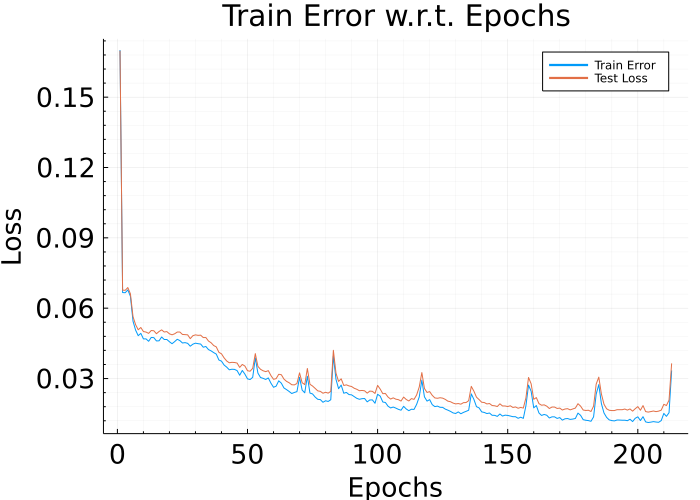

In [17]:
plot_error_curve(trn_loss_list, tst_loss_list)